In [1]:
# First open up the dataset and load it into np

import numpy as np
import csv

dataPath = 'Dataset/listings.csv'

with open(dataPath, 'r') as fp:
    reader = csv.reader(fp, delimiter=',')
    headers = next(reader)
    data = np.array(list(reader))
    
print("done loading data")

done loading data


In [2]:
# Filter only Manhattan to test
manhattanData = []
for i in range(len(data)):
    point = data[i]
    if(point[28] == 'Manhattan'):
        manhattanData.append(point)

print("Got all listings in Manhattan")

Got all listings in Manhattan


In [3]:
import re
# Build a np array of location, price, and size of the house

np.zeros((len(manhattanData), 7))
ar = []

for i in range(len(manhattanData)):
    try:
        if(len(manhattanData[i][29]) != 0 and len(manhattanData[i][30]) != 0 and len(manhattanData[i][39]) != 0 and len(manhattanData[i][33]) != 0 and len(manhattanData[i][35]) != 0 and len(manhattanData[i][36]) != 0 and len(manhattanData[i][37]) != 0):
            ar.append([float(manhattanData[i][29]), 
                       float(manhattanData[i][30]),
                       int(re.findall("\d+\.\d+|\d+", manhattanData[i][33])[0]),
                       int(re.findall("\d+\.\d+|\d+", manhattanData[i][35])[0]),
                       int(re.findall("\d+\.\d+|\d+", manhattanData[i][36])[0]), 
                       int(re.findall("\d+\.\d+|\d+", manhattanData[i][37])[0]),
                       float((manhattanData[i][39]).replace('$','').replace(',',''))])
    except:
        pass
    
sizeData = np.array(ar)
print("Done")

Done


In [14]:
# Build Keras Neural Net showing price estimate disregarding location
t = sizeData[:,6]
x = sizeData[:,2:6]

# Occupants, baths, bedrooms, beds

# First normalize data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
# x = sc.fit_transform(x)

# Split into training and test set
from sklearn.model_selection import train_test_split
x_train, x_test, t_train, t_test = train_test_split(x,t,test_size=0.1)

# Build Neural Net
import keras
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(256,input_dim=4, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile
model.compile(loss='mean_absolute_percentage_error', optimizer='adam')

print("done")

history = model.fit(x_train, t_train, epochs=25, batch_size=256, validation_data = (x_test, t_test), verbose = 1)

done
Epoch 1/25
44/44 [==============================] - 2s 15ms/step - loss: 66.9584 - val_loss: 42.0145
Epoch 2/25
44/44 [==============================] - 0s 5ms/step - loss: 41.4179 - val_loss: 40.3300
Epoch 3/25
44/44 [==============================] - 0s 5ms/step - loss: 40.7603 - val_loss: 40.1085
Epoch 4/25
44/44 [==============================] - 0s 6ms/step - loss: 40.4600 - val_loss: 40.6712
Epoch 5/25
44/44 [==============================] - 0s 9ms/step - loss: 40.3315 - val_loss: 39.8297
Epoch 6/25
44/44 [==============================] - 0s 5ms/step - loss: 40.2669 - val_loss: 39.7506
Epoch 7/25
44/44 [==============================] - 0s 5ms/step - loss: 40.1451 - val_loss: 39.8688
Epoch 8/25
44/44 [==============================] - 0s 7ms/step - loss: 40.2533 - val_loss: 39.6167
Epoch 9/25
44/44 [==============================] - 1s 18ms/step - loss: 40.1089 - val_loss: 39.6221
Epoch 10/25
44/44 [==============================] - 0s 5ms/step - loss: 40.1982 - val_loss: 

<function matplotlib.pyplot.show(close=None, block=None)>

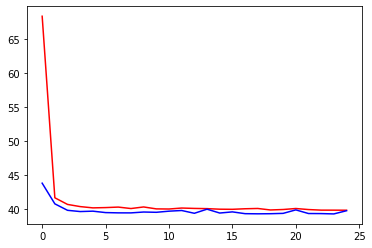

In [5]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], c='r')
plt.plot(history.history['val_loss'], c='b')
plt.show

In [28]:
# Occupants, baths, bedrooms, beds
testPoint = [2,1,1,1]
print(testPoint)
result = model.predict(np.array([testPoint]))[0]
print(result)

[2, 1, 1, 1]
[92.944]


In [30]:
# Adding weight to a listings location

# Function to get distance value of a cord from a reference cord, the reference cord will be max val and the further away the quicker it drops off
import math

def calcDistance(refLat, refLng, targetLat, targetLng):
    R = 6371e3 #metres
    φ1 = targetLat * math.pi/180 # φ, λ in radians
    φ2 = refLat * math.pi/180
    Δφ = (refLat-targetLat) * math.pi/180
    Δλ = (refLng-targetLng) * math.pi/180

    a = math.sin(Δφ/2) * math.sin(Δφ/2) + math.cos(φ1) * math.cos(φ2) * math.sin(Δλ/2) * math.sin(Δλ/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))

    d = R * c #in metres
    return d

# Return the distance weight, 
# dist is how far from the original point 
# maxVal is the value returned at distance from point = 0
# falloff is how fast the returned value approaches 0, has to be below 1, greater than 0, closer to 0 is faster falloff
def calcDistanceWeight(dist, maxVal, falloff):
    return math.exp(-(falloff) * dist)*maxVal

In [74]:
# Get first MAX_LISTINGS or listings within a distance

def generateDistanceData(sizeData, lat, lng):
    distance = np.zeros((len(sizeData),1))
    distanceArray = np.hstack((distance,sizeData))
#     testLat = -73.96528
#     testLong = 40.75864
    testLat = lat
    testLong = lng
    # Add distance from sample location as a column
    for i in range(len(distanceArray)):
        distanceArray[i][0] = calcDistance(testLat, testLong, distanceArray[i][2], distanceArray[i][1])

    sortedDistanceArray = distanceArray[distanceArray[:, 0].argsort()]
    
    return sortedDistanceArray

In [60]:
# Augment dataset to have calcDistanceWeight() duplicates

def augmentDataset(sortedDistanceArray):
    maxVal = 100 #Closest points have 100 times the weight
    falloff = .001 #Limits to 4.6km away

    augmentedDataset = []

    for i in range(len(sortedDistanceArray)):
        weight = int(calcDistanceWeight(sortedDistanceArray[i][0], maxVal, falloff))
        for j in range(weight):
            augmentedDataset.append(sortedDistanceArray[i])

    augmentedDataset = np.array(augmentedDataset)
    return augmentedDataset

print(len(augmentedDataset[:,0]))

153697


In [86]:
# Retrain on new augmented dataset for all points in city
minLat = min(sizeData[:,0])
maxLat = max(sizeData[:,0])
minLng = min(sizeData[:,1])
maxLng = max(sizeData[:,1])

# Generate points we want to test and train on 

lats = np.linspace(minLat, maxLat, 10)
longs = np.linspace(minLng, maxLng, 20)

prices = np.zeros((len(lats),len(longs)))

for i in range(len(lats)):
    for j in range(len(longs)):
#      Create points with distance values
        distanceArray = generateDistanceData(sizeData, lats[i], longs[j])
        print(str(lat) + ", " + str(lng))
#     Train model on these points
        model = Sequential()
        model.add(Dense(256,input_dim=4, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(1, activation='linear'))

        # Compile
        model.compile(loss='mean_absolute_percentage_error', optimizer='adam')
        history = model.fit(x_train, t_train, epochs=5, batch_size=256, verbose = 1)
#     Make a prediction for a 2 person 1 bed one bath property
        testPoint = [2,1,1,1]
        result = model.predict(np.array([testPoint]))[0][0]
        print(result)
        prices[i][j] = result



40.70242, -74.01869
Epoch 1/5
44/44 [==============================] - 1s 7ms/step - loss: 74.1444
Epoch 2/5
44/44 [==============================] - 0s 7ms/step - loss: 41.5495
Epoch 3/5
44/44 [==============================] - 0s 11ms/step - loss: 40.8307
Epoch 4/5
44/44 [==============================] - 0s 5ms/step - loss: 40.5097
Epoch 5/5
44/44 [==============================] - 0s 7ms/step - loss: 40.4083
90.934326
40.70242, -74.01869
Epoch 1/5
44/44 [==============================] - 1s 5ms/step - loss: 70.4956
Epoch 2/5
44/44 [==============================] - 0s 6ms/step - loss: 41.4931
Epoch 3/5
44/44 [==============================] - 0s 7ms/step - loss: 40.7575
Epoch 4/5
44/44 [==============================] - 1s 15ms/step - loss: 40.5022
Epoch 5/5
44/44 [==============================] - 0s 6ms/step - loss: 40.3840
96.19054
40.70242, -74.01869
Epoch 1/5
44/44 [==============================] - 1s 6ms/step - loss: 69.2905
Epoch 2/5
44/44 [==============================] -

44/44 [==============================] - 0s 7ms/step - loss: 40.2902
99.32997
40.70242, -74.01869
Epoch 1/5
44/44 [==============================] - 1s 4ms/step - loss: 70.1180
Epoch 2/5
44/44 [==============================] - 0s 5ms/step - loss: 41.3821
Epoch 3/5
44/44 [==============================] - 0s 5ms/step - loss: 40.7997
Epoch 4/5
44/44 [==============================] - 0s 4ms/step - loss: 40.4301
Epoch 5/5
44/44 [==============================] - 0s 4ms/step - loss: 40.3312
94.40347
40.70242, -74.01869
Epoch 1/5
44/44 [==============================] - 1s 5ms/step - loss: 64.9932
Epoch 2/5
44/44 [==============================] - 0s 4ms/step - loss: 41.3400
Epoch 3/5
44/44 [==============================] - 0s 4ms/step - loss: 40.7375
Epoch 4/5
44/44 [==============================] - 0s 4ms/step - loss: 40.4320
Epoch 5/5
44/44 [==============================] - 0s 4ms/step - loss: 40.2090
94.957695
40.70242, -74.01869
Epoch 1/5
44/44 [==============================] - 1s

44/44 [==============================] - 1s 5ms/step - loss: 66.3341
Epoch 2/5
44/44 [==============================] - 0s 4ms/step - loss: 41.3830
Epoch 3/5
44/44 [==============================] - 0s 6ms/step - loss: 40.6755
Epoch 4/5
44/44 [==============================] - 0s 5ms/step - loss: 40.3881
Epoch 5/5
44/44 [==============================] - 0s 5ms/step - loss: 40.3079
97.5549
40.70242, -74.01869
Epoch 1/5
44/44 [==============================] - 1s 5ms/step - loss: 68.7262
Epoch 2/5
44/44 [==============================] - 0s 5ms/step - loss: 41.6401
Epoch 3/5
44/44 [==============================] - 0s 5ms/step - loss: 40.7084
Epoch 4/5
44/44 [==============================] - 0s 4ms/step - loss: 40.4348
Epoch 5/5
44/44 [==============================] - 0s 5ms/step - loss: 40.3761
91.43122
40.70242, -74.01869
Epoch 1/5
44/44 [==============================] - 1s 5ms/step - loss: 71.0296
Epoch 2/5
44/44 [==============================] - 0s 4ms/step - loss: 41.6132
Epoch

44/44 [==============================] - 0s 5ms/step - loss: 41.5629
Epoch 3/5
44/44 [==============================] - 0s 5ms/step - loss: 40.8023
Epoch 4/5
44/44 [==============================] - 0s 5ms/step - loss: 40.5134
Epoch 5/5
44/44 [==============================] - 0s 5ms/step - loss: 40.2833
98.52722
40.70242, -74.01869
Epoch 1/5
44/44 [==============================] - 1s 5ms/step - loss: 68.9244
Epoch 2/5
44/44 [==============================] - 0s 5ms/step - loss: 41.4606
Epoch 3/5
44/44 [==============================] - 0s 5ms/step - loss: 40.8732
Epoch 4/5
44/44 [==============================] - 0s 4ms/step - loss: 40.5218
Epoch 5/5
44/44 [==============================] - 0s 5ms/step - loss: 40.4711
94.13955
40.70242, -74.01869
Epoch 1/5
44/44 [==============================] - 1s 4ms/step - loss: 68.2245
Epoch 2/5
44/44 [==============================] - 0s 5ms/step - loss: 41.3552
Epoch 3/5
44/44 [==============================] - 0s 5ms/step - loss: 40.7063
Epoc

44/44 [==============================] - 0s 5ms/step - loss: 40.8090
Epoch 4/5
44/44 [==============================] - 0s 5ms/step - loss: 40.4648
Epoch 5/5
44/44 [==============================] - 0s 5ms/step - loss: 40.4390
93.883514
40.70242, -74.01869
Epoch 1/5
44/44 [==============================] - 1s 4ms/step - loss: 70.0462
Epoch 2/5
44/44 [==============================] - 0s 4ms/step - loss: 41.6015
Epoch 3/5
44/44 [==============================] - 0s 4ms/step - loss: 40.8133
Epoch 4/5
44/44 [==============================] - 0s 4ms/step - loss: 40.5071
Epoch 5/5
44/44 [==============================] - 0s 4ms/step - loss: 40.3350
98.138176
40.70242, -74.01869
Epoch 1/5
44/44 [==============================] - 1s 5ms/step - loss: 72.0000
Epoch 2/5
44/44 [==============================] - 0s 5ms/step - loss: 41.4084
Epoch 3/5
44/44 [==============================] - 0s 4ms/step - loss: 40.7528
Epoch 4/5
44/44 [==============================] - 0s 5ms/step - loss: 40.7030
Ep

44/44 [==============================] - 0s 5ms/step - loss: 40.4979
Epoch 5/5
44/44 [==============================] - 0s 6ms/step - loss: 40.3054
97.55864
40.70242, -74.01869
Epoch 1/5
44/44 [==============================] - 1s 4ms/step - loss: 67.8711
Epoch 2/5
44/44 [==============================] - 0s 4ms/step - loss: 41.3737
Epoch 3/5
44/44 [==============================] - 0s 5ms/step - loss: 40.8070
Epoch 4/5
44/44 [==============================] - 0s 5ms/step - loss: 40.4811
Epoch 5/5
44/44 [==============================] - 0s 5ms/step - loss: 40.3689
99.54359
40.70242, -74.01869
Epoch 1/5
44/44 [==============================] - 1s 5ms/step - loss: 70.2834
Epoch 2/5
44/44 [==============================] - 0s 4ms/step - loss: 41.5307
Epoch 3/5
44/44 [==============================] - 0s 5ms/step - loss: 40.7934
Epoch 4/5
44/44 [==============================] - 0s 5ms/step - loss: 40.5705
Epoch 5/5
44/44 [==============================] - 0s 5ms/step - loss: 40.4351
93.3

44/44 [==============================] - 0s 5ms/step - loss: 40.4313
95.959274
40.70242, -74.01869
Epoch 1/5
44/44 [==============================] - 1s 6ms/step - loss: 68.1581
Epoch 2/5
44/44 [==============================] - 0s 4ms/step - loss: 41.6795
Epoch 3/5
44/44 [==============================] - 0s 4ms/step - loss: 40.8432
Epoch 4/5
44/44 [==============================] - 0s 4ms/step - loss: 40.5168
Epoch 5/5
44/44 [==============================] - 0s 4ms/step - loss: 40.4470
92.85699
40.70242, -74.01869
Epoch 1/5
44/44 [==============================] - 1s 4ms/step - loss: 70.9542
Epoch 2/5
44/44 [==============================] - 0s 5ms/step - loss: 41.9840
Epoch 3/5
44/44 [==============================] - 0s 4ms/step - loss: 40.8979
Epoch 4/5
44/44 [==============================] - 0s 5ms/step - loss: 40.4821
Epoch 5/5
44/44 [==============================] - 0s 5ms/step - loss: 40.3177
96.55074
40.70242, -74.01869
Epoch 1/5
44/44 [==============================] - 1s

44/44 [==============================] - 1s 5ms/step - loss: 72.0769
Epoch 2/5
44/44 [==============================] - 0s 5ms/step - loss: 41.6152
Epoch 3/5
44/44 [==============================] - 0s 5ms/step - loss: 40.8437
Epoch 4/5
44/44 [==============================] - 0s 5ms/step - loss: 40.5688
Epoch 5/5
44/44 [==============================] - 0s 5ms/step - loss: 40.3251
94.99241
40.70242, -74.01869
Epoch 1/5
44/44 [==============================] - 1s 5ms/step - loss: 64.7554
Epoch 2/5
44/44 [==============================] - 0s 5ms/step - loss: 41.2124
Epoch 3/5
44/44 [==============================] - 0s 5ms/step - loss: 40.6720
Epoch 4/5
44/44 [==============================] - 0s 5ms/step - loss: 40.3761
Epoch 5/5
44/44 [==============================] - 0s 5ms/step - loss: 40.2953
98.84939
40.70242, -74.01869
Epoch 1/5
44/44 [==============================] - 1s 4ms/step - loss: 69.6362
Epoch 2/5
44/44 [==============================] - 0s 6ms/step - loss: 41.5614
Epoc

44/44 [==============================] - 0s 5ms/step - loss: 41.6009
Epoch 3/5
44/44 [==============================] - 0s 5ms/step - loss: 40.6370
Epoch 4/5
44/44 [==============================] - 0s 4ms/step - loss: 40.3521
Epoch 5/5
44/44 [==============================] - 0s 5ms/step - loss: 40.3304
90.00259
40.70242, -74.01869
Epoch 1/5
44/44 [==============================] - 1s 5ms/step - loss: 79.0255
Epoch 2/5
44/44 [==============================] - 0s 4ms/step - loss: 41.8725
Epoch 3/5
44/44 [==============================] - 0s 5ms/step - loss: 40.8929
Epoch 4/5
44/44 [==============================] - 0s 5ms/step - loss: 40.5967
Epoch 5/5
44/44 [==============================] - 0s 4ms/step - loss: 40.4059
97.22559
40.70242, -74.01869
Epoch 1/5
44/44 [==============================] - 1s 5ms/step - loss: 68.0583
Epoch 2/5
44/44 [==============================] - 0s 5ms/step - loss: 41.4270
Epoch 3/5
44/44 [==============================] - 0s 5ms/step - loss: 40.8709
Epoc

44/44 [==============================] - 0s 6ms/step - loss: 40.7602
Epoch 4/5
44/44 [==============================] - 0s 5ms/step - loss: 40.5531
Epoch 5/5
44/44 [==============================] - 0s 5ms/step - loss: 40.3492
95.29458
40.70242, -74.01869
Epoch 1/5
44/44 [==============================] - 1s 5ms/step - loss: 68.5424
Epoch 2/5
44/44 [==============================] - 0s 5ms/step - loss: 41.3889
Epoch 3/5
44/44 [==============================] - 0s 5ms/step - loss: 40.6774
Epoch 4/5
44/44 [==============================] - 0s 5ms/step - loss: 40.4167
Epoch 5/5
44/44 [==============================] - 0s 5ms/step - loss: 40.3241
93.847664
40.70242, -74.01869
Epoch 1/5
44/44 [==============================] - 1s 5ms/step - loss: 70.4653
Epoch 2/5
44/44 [==============================] - 0s 5ms/step - loss: 41.9075
Epoch 3/5
44/44 [==============================] - 0s 5ms/step - loss: 40.7859
Epoch 4/5
44/44 [==============================] - 0s 5ms/step - loss: 40.3412
Epo

44/44 [==============================] - 0s 5ms/step - loss: 40.4130
Epoch 5/5
44/44 [==============================] - 0s 5ms/step - loss: 40.2041
99.88683
40.70242, -74.01869
Epoch 1/5
44/44 [==============================] - 1s 4ms/step - loss: 67.5493
Epoch 2/5
44/44 [==============================] - 0s 4ms/step - loss: 41.4905
Epoch 3/5
44/44 [==============================] - 0s 5ms/step - loss: 40.6279
Epoch 4/5
44/44 [==============================] - 0s 4ms/step - loss: 40.4435
Epoch 5/5
44/44 [==============================] - 0s 4ms/step - loss: 40.2882
93.44738
40.70242, -74.01869
Epoch 1/5
44/44 [==============================] - 1s 5ms/step - loss: 67.9265
Epoch 2/5
44/44 [==============================] - 0s 5ms/step - loss: 41.2555
Epoch 3/5
44/44 [==============================] - 0s 5ms/step - loss: 40.5786
Epoch 4/5
44/44 [==============================] - 0s 4ms/step - loss: 40.5420
Epoch 5/5
44/44 [==============================] - 0s 5ms/step - loss: 40.5533
94.5

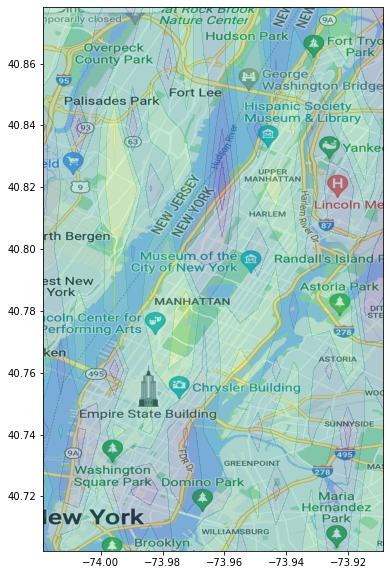

In [117]:
# Display results
img = plt.imread("ManhattenMap.png")
fig, ax = plt.subplots()
ax.imshow(img, extent=[minLng, maxLng, minLat, maxLat])

X, Y = np.meshgrid(longs, lats)
plt.contourf(X, Y, prices, alpha=.3)
plt.colorbar(c1, ax=axes[0])
plt.rcParams['figure.figsize'] = [30, 10]
plt.show()